In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.linalg.interpolative import estimate_spectral_norm
from scipy.sparse.linalg import LinearOperator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [19]:
Transform = transforms.ToTensor()
train = datasets.MNIST(root='models/data', train=True, download=False, transform=Transform)
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: models/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [20]:
test = datasets.MNIST(root='models/data', train=False, download=False, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: models/data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [21]:
image, label = train[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


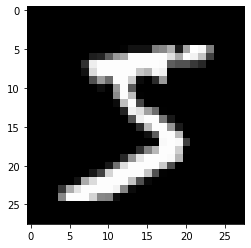

In [22]:
plt.imshow(image.reshape((28, 28)), cmap='gray')

In [23]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=500, shuffle=False)

In [24]:
# Réseau de neurones MLP avec fonctions d'activation 1-Lipschitz
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layers[0])
        self.d2 = nn.Linear(layers[0], layers[1])
        self.d3 = nn.Linear(layers[1], output_size)
        
    def forward(self, X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)

In [25]:
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy: {trn_corr.item()*100/60000:.3f}%')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  0 batch:  600 [ 60000/60000] Train loss: 0.29660809 Train accuracy: 88.553%
epoch:  1 batch:  600 [ 60000/60000] Train loss: 0.11026100 Train accuracy: 95.002%
epoch:  2 batch:  600 [ 60000/60000] Train loss: 0.07607977 Train accuracy: 96.415%
epoch:  3 batch:  600 [ 60000/60000] Train loss: 0.05830932 Train accuracy: 97.265%
epoch:  4 batch:  600 [ 60000/60000] Train loss: 0.12338138 Train accuracy: 97.830%
epoch:  5 batch:  600 [ 60000/60000] Train loss: 0.06507113 Train accuracy: 98.327%
epoch:  6 batch:  600 [ 60000/60000] Train loss: 0.04398085 Train accuracy: 98.598%
epoch:  7 batch:  600 [ 60000/60000] Train loss: 0.03924252 Train accuracy: 98.835%
epoch:  8 batch:  600 [ 60000/60000] Train loss: 0.10232236 Train accuracy: 98.998%
epoch:  9 batch:  600 [ 60000/60000] Train loss: 0.03470717 Train accuracy: 99.243%


In [28]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 97.830%


In [35]:
model.d1.weight

Parameter containing:
tensor([[ 0.0102,  0.0142,  0.0253,  ...,  0.0343, -0.0228,  0.0206],
        [ 0.0219,  0.0154, -0.0323,  ...,  0.0089,  0.0191, -0.0296],
        [-0.0326, -0.0275,  0.0255,  ...,  0.0284,  0.0018, -0.0187],
        ...,
        [ 0.0020, -0.0010,  0.0281,  ...,  0.0289, -0.0241,  0.0323],
        [-0.0215, -0.0343, -0.0015,  ...,  0.0280, -0.0327,  0.0229],
        [ 0.0116,  0.0002, -0.0197,  ...,  0.0324, -0.0195, -0.0105]],
       requires_grad=True)

In [39]:
nrm1 = torch.linalg.norm(model.d1.weight, ord=2)
nrm1

tensor(9.2121, grad_fn=<CopyBackwards>)

In [40]:
nrm2 = torch.linalg.norm(model.d2.weight, ord=2)
nrm2

tensor(4.7328, grad_fn=<CopyBackwards>)

In [41]:
nrm3 = torch.linalg.norm(model.d3.weight, ord=2)
nrm3

tensor(2.2266, grad_fn=<CopyBackwards>)

In [43]:
L_hat_AL = nrm1 * nrm2 * nrm3
L_hat_AL

tensor(97.0800, grad_fn=<MulBackward0>)